# Synthetic Data Generation Baseline

In [128]:
import os, sys
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
import pickle
import sklearn
import tqdm.notebook as tqdm

from sklearn.model_selection import train_test_split
sns.set_theme()
sys.path.append(os.path.abspath('..'))

torch.backends.cudnn.benchmark = True

In [129]:
%load_ext autoreload
%autoreload 2

from lib.vae_models import VAE, CVAE
import lib.datasets as datasets
import lib.utils as utils
from lib.lda_lib import EntityEncoder

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import Data

In [130]:
DATASET_NAME = 'goi4_dp_full_Gipuzkoa'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [131]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 2522880 consumption profiles from 365 dates and 6912 users


In [132]:
date_dict = np.load(f'../data/{DATASET_NAME}/encode_dict.npy', allow_pickle=True).item()["date_dict"]
date_dict_inv = {v: k for k, v in date_dict.items()}

In [133]:
if not os.path.exists(f'../data/{DATASET_NAME}/raw_dates.npy'):
    raw_dates = np.array([datetime.datetime.strptime(date_dict_inv[d], '%Y-%m-%d') for d in dates])
    np.save(f'../data/{DATASET_NAME}/raw_dates.npy', raw_dates)
else:
    raw_dates = np.load(f'../data/{DATASET_NAME}/raw_dates.npy', allow_pickle=True)

In [134]:
metadata = pd.read_csv(f'../data/{DATASET_NAME}/metadata.csv')

In [135]:
unique_provinces = metadata.province.unique()
print(f'Loaded metadata for {len(unique_provinces)} provinces')
print(f"Uniqe provinces are: {unique_provinces}")

Loaded metadata for 1 provinces
Uniqe provinces are: ['Gipuzkoa']


### Prepare Conditions

In [136]:
months = np.array([d.month for d in raw_dates])
weekdays = np.array([d.weekday() for d in raw_dates])
is_weekend = np.array([int(d.weekday() >= 5) for d in raw_dates])

In [137]:
df_temp = pd.read_csv(f'../data/{DATASET_NAME}/spain_temp_daily.csv')
df_temp.index = pd.to_datetime(df_temp['date'])
df_temp.drop(columns='date', inplace=True)
df_temp = df_temp.loc[raw_dates]

In [138]:
df_prec = pd.read_csv(f'../data/{DATASET_NAME}/spain_prec_daily.csv')
df_prec.index = pd.to_datetime(df_prec['date'])
df_prec.drop(columns='date', inplace=True)
df_prec = df_prec.loc[raw_dates]
df_prec = df_prec.sort_values(by='prec_total')

In [139]:
condition_kwargs = {}

In [140]:
ADD_MONTHS = True
ADD_WEEKDAYS = True
ADD_IS_WEEKEND = False
ADD_TEMPERATURE_MIN = False
ADD_TEMPERATURE_MAXDELTA = False
ADD_PRECIPITATION_LEVEL = False

condition_kwargs["tags"], condition_kwargs["types"], condition_kwargs["supports"], condition_set  = [], [], [], {}
if ADD_MONTHS: 
    condition_kwargs["tags"].append("months")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(months).tolist())
    condition_set["months"] = months[...,None]
if ADD_WEEKDAYS: 
    condition_kwargs["tags"].append("weekdays")
    condition_kwargs["types"].append("circ")
    condition_kwargs["supports"].append(np.unique(weekdays).tolist())
    condition_set["weekdays"] = weekdays[...,None]
if ADD_IS_WEEKEND:
    condition_kwargs["tags"].append("is_weekend")
    condition_kwargs["types"].append("cat")
    condition_kwargs["supports"].append([0, 1])
    condition_set["is_weekend"] = is_weekend[...,None]
if ADD_TEMPERATURE_MIN:
    condition_kwargs["tags"].append("temp_min")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_min"] = df_temp[condition_kwargs["tags"][-1]].values[...,None]
if ADD_TEMPERATURE_MAXDELTA:
    condition_kwargs["tags"].append("temp_max_delta")
    condition_kwargs["types"].append("cont")
    condition_kwargs["supports"].append([df_temp[condition_kwargs["tags"][-1]].min(), df_temp[condition_kwargs["tags"][-1]].max()])
    condition_set["temp_max_delta"] = df_temp[condition_kwargs["tags"][-1]].values[...,None]
if ADD_PRECIPITATION_LEVEL:
    condition_kwargs["tags"].append("precipitation_level")
    condition_kwargs["types"].append("ord")
    condition_kwargs["supports"].append(np.unique(df_prec["label"]).tolist())
    condition_set["precipitation_level"] = df_prec["label"].values[...,None]


In [141]:
conditioner = datasets.Conditioner(**condition_kwargs, condition_set=condition_set)

#### Set Resolution

In [142]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = np.reshape(data, (-1, 24))
    X = np.reshape(np.concatenate([X[:,6:], X[:,:6]], axis=-1), (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)    #circle shift the last dimension of X
else:
    X = np.reshape(data, (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)
    X = np.concatenate((X[:,:-2,-6:], X[:,1:-1,:], X[:,2:,:6]), axis=-1)

condition_set = {k: np.reshape(v, (num_users, num_days, -1)) for k, v in condition_set.items()}
condition_set = {k: v[:,1:-1,:] for k, v in condition_set.items()}

num_days = X.shape[1]

#### Clean Data

In [143]:
nonzero_user_mask = np.sum(np.all(X == 0, axis=2), axis=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = np.sum(np.any(X < 0, axis=2), axis=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask
X = X[user_mask]
condition_set = {k: v[user_mask] for k, v in condition_set.items()}

Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles


#### Ampute the Dataset

In [144]:
np.random.seed(RANDOM_SEED)
n, a, b = num_days, 0.85, 10.0
# n, a, b = num_days, 1.0, 1.0
missing_days = np.random.binomial(n, p=np.random.beta(a, b, size=X.shape[0]), size=X.shape[0])
print(f"Mean of missing days: {n*a/(a+b):.2f}")

Mean of missing days: 28.44


In [145]:
X_missing = X.copy().astype(float)
condition_missing = {k: v.copy().astype(float) for k, v in condition_set.items()}

for user in range(X.shape[0]): 
    X_missing[user, :missing_days[user]] = np.nan
    for k in condition_missing.keys():
        condition_missing[k][user, :missing_days[user]] = np.nan

#### Subsample the Dataset

In [146]:
USER_SUBSAMPLE_RATE, DAY_SUBSAMPLE_RATE = 10, 1
X, X_missing = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :], X_missing[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
condition_set = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_set.items()}
condition_missing = {k: v[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :] for k, v in condition_missing.items()}
num_users, num_days, num_features = X.shape
X_gt_list = [X[user, :missing_days[user]]*1 for user in range(num_users)]
X_gt_condition_list = {k: [v[user, :missing_days[user]]*1 for user in range(num_users)] for k, v in condition_set.items()}

print("{:.<40}{:.>5}".format("Number of (subsampled/filtered) users", num_users))
print("{:.<40}{:.>5}".format("Number of (subsampled) days", num_days))
print("{:.<40}{:.>5}".format("Number of (aggregated) features", num_features))

Number of (subsampled/filtered) users.....683
Number of (subsampled) days...............363
Number of (aggregated) features............36


In [147]:
missing_idx_mat  = np.isnan(X_missing).any(2)
missing_num_labels = {"user": missing_idx_mat.sum(1), "day": missing_idx_mat.sum(0) }

In [148]:
X_missing = X_missing.reshape(-1, num_features)
conditions_missing = {k: v.reshape(-1, v.shape[-1]) for k, v in condition_missing.items()}
missing_idx = np.isnan(X_missing.sum(1))

#### Prepare the Training Data with Missing Records

In [149]:
DISCRETE = False

if DISCRETE:
    ## discretize the data
    ... #TODO
else:
    SHIFT = 1.0
    ZERO_ID = -3
    LOG_SPACE = True
    nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_missing)
    X_missing = utils.zero_preserved_log_normalize(X_missing, nonzero_mean, nonzero_std, log_output=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)

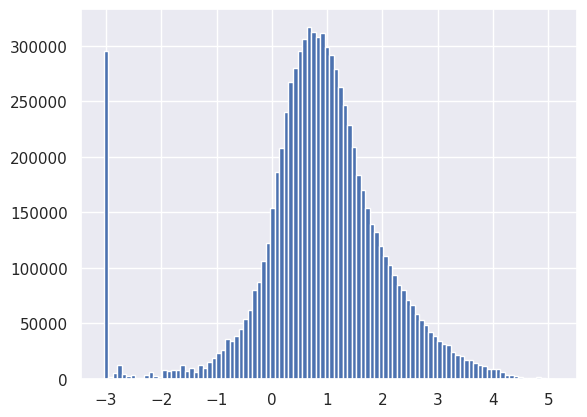

In [150]:
plt.hist(X_missing.flatten(), bins=100)
plt.show()

## User Encodings

In [151]:
NUM_TOPICS = 20
VOCAB_SIZE = 1000
ALPHA = 1.0/NUM_TOPICS
fit_kwargs = {"lda": {'doc_topic_prior': ALPHA,  ## alpha
                      'topic_word_prior': 1.0/VOCAB_SIZE, ## eta
                      'perp_tol': 5e-2, 
                      'max_iter': 100, ## number of epochs
                      'batch_size': 64, 
                      'verbose': True, 
                      'learning_method': 'online', 
                      'evaluate_every': 10,
                      'n_jobs': -1},}

In [154]:
entity_model = EntityEncoder(num_topics=NUM_TOPICS, reduce_dim=False, num_clusters=VOCAB_SIZE, random_state=RANDOM_SEED).fit(X_missing.reshape(num_users, num_days, -1), fit_kwargs)

Clustering...
Init 1/1 with method k-means++
Inertia for init 1/1: 193796.15658243746
[MiniBatchKMeans] Reassigning 379 cluster centers.
Minibatch step 1/2783: mean batch inertia: 7.917101088171425
Minibatch step 2/2783: mean batch inertia: 7.775153655171167, ewa inertia: 7.775153655171167
[MiniBatchKMeans] Reassigning 123 cluster centers.
Minibatch step 3/2783: mean batch inertia: 7.513461880541572, ewa inertia: 7.756350225491615
Minibatch step 4/2783: mean batch inertia: 7.471919582190425, ewa inertia: 7.735912932009259
[MiniBatchKMeans] Reassigning 36 cluster centers.
Minibatch step 5/2783: mean batch inertia: 7.422816748839176, ewa inertia: 7.713415923566759
Minibatch step 6/2783: mean batch inertia: 7.291118587564909, ewa inertia: 7.68307244688465
[MiniBatchKMeans] Reassigning 37 cluster centers.
Minibatch step 7/2783: mean batch inertia: 7.089445769675095, ewa inertia: 7.64041838373492
Minibatch step 8/2783: mean batch inertia: 7.147265262752147, ewa inertia: 7.604983681804468
[M

1307.97s - Could not connect to 127.0.0.1: 47753
Traceback (most recent call last):
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 493, in start_client
    s.connect((host, port))
socket.timeout: timed out
1308.05s - Could not connect to 127.0.0.1: 47753
Traceback (most recent call last):
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 493, in start_client
    s.connect((host, port))
socket.timeout: timed out
1308.12s - Could not connect to 127.0.0.1: 47753
Traceback (most recent call last):
  File "/home/kbolat/.conda/envs/torchenv/lib/python3.9/site-packages/debugpy/_vendored/pydevd/_pydevd_bundle/pydevd_comm.py", line 493, in start_client
    s.connect((host, port))
socket.timeout: timed out
1308.21s - Could not connect to 127.0.0.1: 47753
Traceback (most recent call last):
  File "/home/kbolat/.conda/envs/torchenv/l

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

ValueError: semaphore or lock released too many times

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {}

In [ ]:
user_gamma = entity_model.transform(X_missing.reshape(num_users, num_days, -1))

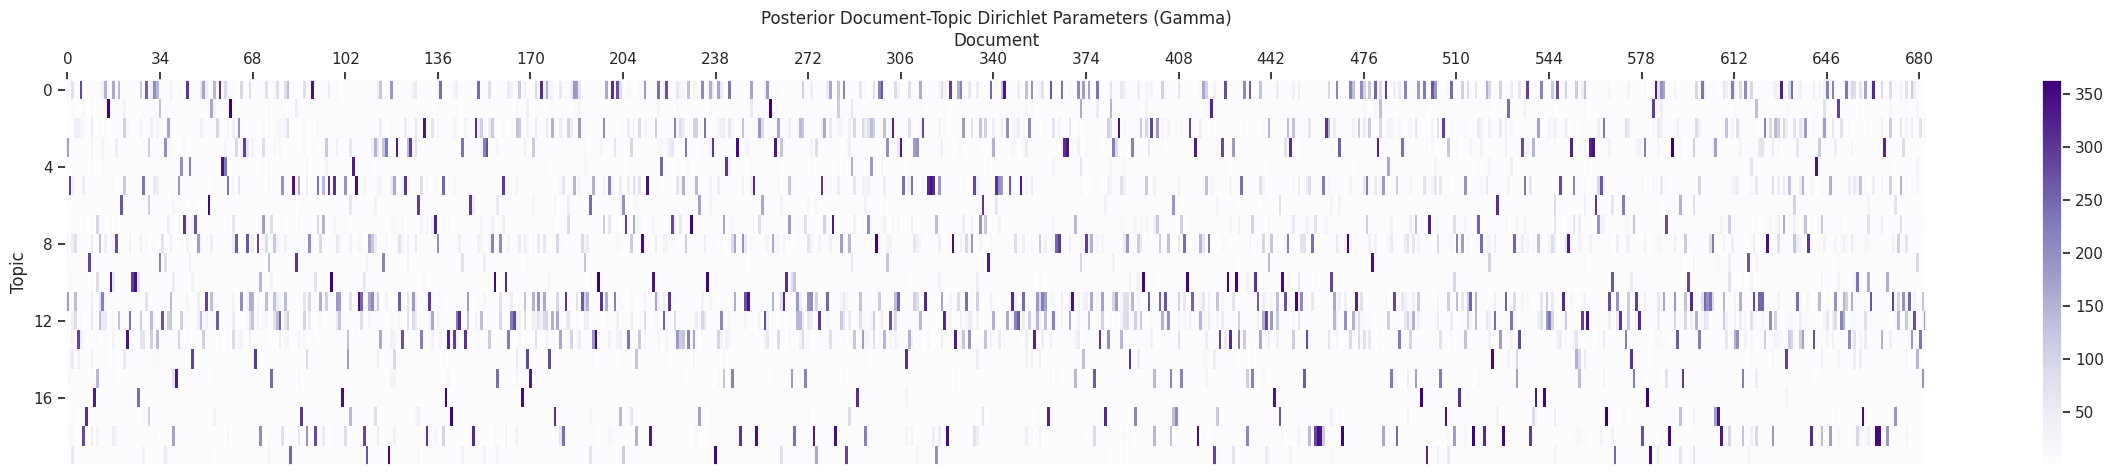

In [ ]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(user_gamma.T, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Posterior Document-Topic Dirichlet Parameters (Gamma)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(NUM_TOPICS))
ax.set_xticks(np.arange(num_users))
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('top')
ax.grid(False)
plt.yticks(np.arange(0, NUM_TOPICS, NUM_TOPICS//5))
plt.xticks(np.arange(0, num_users, num_users//20))
fig.colorbar(im, ax=ax)
plt.show()

### Turn embeddings into conditions

In [ ]:
conditioner.add_condition(tag="users", typ="dir", support=[ALPHA, entity_model.doc_lengths.max()], data=user_gamma)

In [ ]:
conditions_missing["users"] = user_gamma.repeat(num_days, axis=0)

## Ctd

In [ ]:
X_missing = X_missing[~missing_idx]
conditions_missing = {k: v[~missing_idx] for k, v in conditions_missing.items()}

In [ ]:
## split the X_missing and conditions_missing into training and validation sets
VAL_RATIO = 0.1
random_idx = np.random.permutation(len(X_missing))
val_idx = random_idx[:int(len(X_missing)*VAL_RATIO)]
train_idx = random_idx[int(len(X_missing)*VAL_RATIO):]

X_train, X_val = X_missing[train_idx], X_missing[val_idx]
conditions_train = {k: v[train_idx] for k, v in conditions_missing.items()}
conditions_val = {k: v[val_idx] for k, v in conditions_missing.items()}

In [ ]:
trainset = datasets.ConditionedDataset(inputs=X_train, conditions=conditions_train, conditioner=conditioner)
valset = datasets.ConditionedDataset(inputs=X_val, conditions=conditions_val, conditioner=conditioner)
print(f"Number of Training Points: {len(trainset)}")
print(f"Number of Validation Points: {len(valset)}")

Number of Training Points: 205218
Number of Validation Points: 22801


### Model

In [ ]:
distribution_dict = {"posterior": {"dist_type": "normal",
                                    "learn_sigma": True,
                                    "sigma_lim": 0.01,
                                    "num_neurons": 300,
                                    "num_hidden_layers": 8,
                                    "dropout": True,
                                    "dropout_rate": 0.20,
                                    "batch_normalization": True,
                                    "resnet": True},
                    "likelihood": {"dist_type": "ndg",
                                    "num_lags": 24,
                                    "continuous_dist_type": "normal", 
                                    "learn_sigma": True,
                                    "sigma_lim": 0.01,
                                    "sigma_fixed": 0.1,
                                    "num_neurons": 300,
                                    "num_hidden_layers": 7,
                                    "dropout": True,
                                    "dropout_rate": 0.20,
                                    "batch_normalization": True,
                                    "resnet": True}
                    }

In [ ]:
model_kwargs = {"latent_dim": 24,
                "condencoding_dim": None,
                "distribution_dict": distribution_dict,
                }

In [ ]:
model = CVAE(input_dim=num_features, conditioner=conditioner, **model_kwargs)
print("Number of encoder parameters:", model.encoder._num_parameters())
print("Number of decoder parameters:", model.decoder._num_parameters())

Number of encoder parameters: 1033248
Number of decoder parameters: 1206636


### Training

In [76]:
train_kwargs = {
                "lr": 5e-4,
                "beta": 1.0,
                "num_mc_samples": 4,
                "epochs": 1000,
                "verbose_freq": 100,
                "tensorboard": True,
                "batch_size": 512,
                "validation_freq": 2500,
                "device": "cuda",
                "tqdm_func": tqdm.tqdm,
                }

In [77]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True, num_workers=1, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*128, drop_last=False, num_workers=1, pin_memory=False)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_kwargs["batch_size"], shuffle=True, drop_last=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*128, drop_last=False)

In [236]:
model.fit(trainloader=trainloader, valloader=valloader, **train_kwargs)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iteration in Epoch:   0%|          | 0/400 [00:00<?, ?it/s]

Iteration: 100 -- ELBO=-8.43e+01 / RLL=-6.49e+01 / KL=1.94e+01
Iteration: 200 -- ELBO=-6.63e+01 / RLL=-5.15e+01 / KL=1.48e+01
Iteration: 300 -- ELBO=-5.93e+01 / RLL=-4.69e+01 / KL=1.24e+01
Iteration: 400 -- ELBO=-5.53e+01 / RLL=-4.38e+01 / KL=1.15e+01
Iteration: 500 -- ELBO=-5.06e+01 / RLL=-4.04e+01 / KL=1.02e+01
Iteration: 600 -- ELBO=-4.86e+01 / RLL=-3.83e+01 / KL=1.03e+01
Iteration: 700 -- ELBO=-4.70e+01 / RLL=-3.77e+01 / KL=9.33e+00
Iteration: 800 -- ELBO=-4.57e+01 / RLL=-3.68e+01 / KL=8.88e+00
Iteration: 900 -- ELBO=-4.44e+01 / RLL=-3.60e+01 / KL=8.37e+00
Iteration: 1000 -- ELBO=-4.37e+01 / RLL=-3.56e+01 / KL=8.12e+00
Iteration: 1100 -- ELBO=-4.14e+01 / RLL=-3.36e+01 / KL=7.79e+00
Iteration: 1200 -- ELBO=-4.17e+01 / RLL=-3.42e+01 / KL=7.47e+00
Iteration: 1300 -- ELBO=-3.96e+01 / RLL=-3.24e+01 / KL=7.18e+00
Iteration: 1400 -- ELBO=-3.92e+01 / RLL=-3.22e+01 / KL=7.00e+00
Iteration: 1500 -- ELBO=-3.91e+01 / RLL=-3.23e+01 / KL=6.83e+00
Iteration: 1600 -- ELBO=-3.82e+01 / RLL=-3.15e+01

KeyboardInterrupt: 

In [237]:
model.to("cpu")
model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
model.eval()

CVAE(
  (encoder): GaussianNN(
    (parameterizer): ParameterizerNN(
      (block_dict): ModuleDict(
        (input): NNBlock(
          (input_layer): Sequential(
            (0): Linear(in_features=60, out_features=300, bias=True)
            (1): Softplus(beta=1.0, threshold=20.0)
            (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (middle_layers): ModuleList(
            (0-7): 8 x Sequential(
              (0): Linear(in_features=300, out_features=300, bias=True)
              (1): Softplus(beta=1.0, threshold=20.0)
              (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (3): Dropout(p=0.2, inplace=False)
            )
          )
          (output_layer): Sequential(
            (0): Linear(in_features=300, out_features=300, bias=True)
            (1): Softplus(beta=1.0, threshold=20.0)
            (2): BatchN

In [238]:
save_path = model.log_dir
model_name = f'trained_model'
model_path = f'./{save_path}/{model_name}.pt'
torch.save(model.state_dict(), model_path)
print(f'Model saved at {model_path}')

Model saved at ./runs/Jun18_07-23-32_iepg-compute1.ewi.tudelft.nl/trained_model.pt


In [239]:
conditioner_path = f'./{save_path}/conditioner.pkl'
with open(conditioner_path, 'wb') as f: pickle.dump(conditioner, f)
print(f'Conditioner saved at {conditioner_path}')

Conditioner saved at ./runs/Jun18_07-23-32_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


## Load the Trained Model (if needed)

In [93]:
LOAD_MODEL = True

model_path = "runs/Jun18_00-54-39_iepg-compute1.ewi.tudelft.nl/trained_model.pt"
conditioner_path = "runs/Jun18_00-54-39_iepg-compute1.ewi.tudelft.nl/conditioner.pkl"

## if model_path is None, load the latest model
if model_path is None:
    model_path = sorted([f for f in os.listdir("runs")])[-1]
    model_path = f'runs/{model_path}/trained_model.pt'

## if conditioner_path is None, load the latest conditioner
if conditioner_path is None:
    conditioner_path = sorted([f for f in os.listdir("runs")])[-1]
    conditioner_path = f'runs/{conditioner_path}/conditioner.pkl'

In [94]:
if LOAD_MODEL:
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to("cpu")
    model.prior_params = {k: v.to("cpu") for k, v in model.prior_params.items()}
    model.eval()

    with open(conditioner_path, 'rb') as f: conditioner = pickle.load(f)

    print(f'Model loaded from {model_path}')
    print(f'Conditioner loaded from {conditioner_path}')

Model loaded from runs/Jun18_00-54-39_iepg-compute1.ewi.tudelft.nl/trained_model.pt
Conditioner loaded from runs/Jun18_00-54-39_iepg-compute1.ewi.tudelft.nl/conditioner.pkl


In [95]:
## validation loss
valloader = torch.utils.data.DataLoader(valset, batch_size=train_kwargs["batch_size"]*128, drop_last=False)
model.validate(valloader)

{'elbo': -15.454089164733887,
 'rll': -10.972825050354004,
 'kl': 4.481264114379883}

## Inspection

### Random sample

In [101]:
random_condition_set, random_conditions = conditioner.get_random_conditions(1)
## get a random user gamma from the entity model
random_user_idx = np.random.choice(user_gamma.shape[0])
random_conditions["users"] = user_gamma[[random_user_idx]]
random_condition_set =  conditioner.transform(random_conditions)
## print random_conditions dictionary as a table
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions.items():
    print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

Condition           Value
months              3.00
weekdays            2.00
users               106.91 0.05 52.98 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 178.26 0.05 0.05 0.05 0.05 0.05 0.05


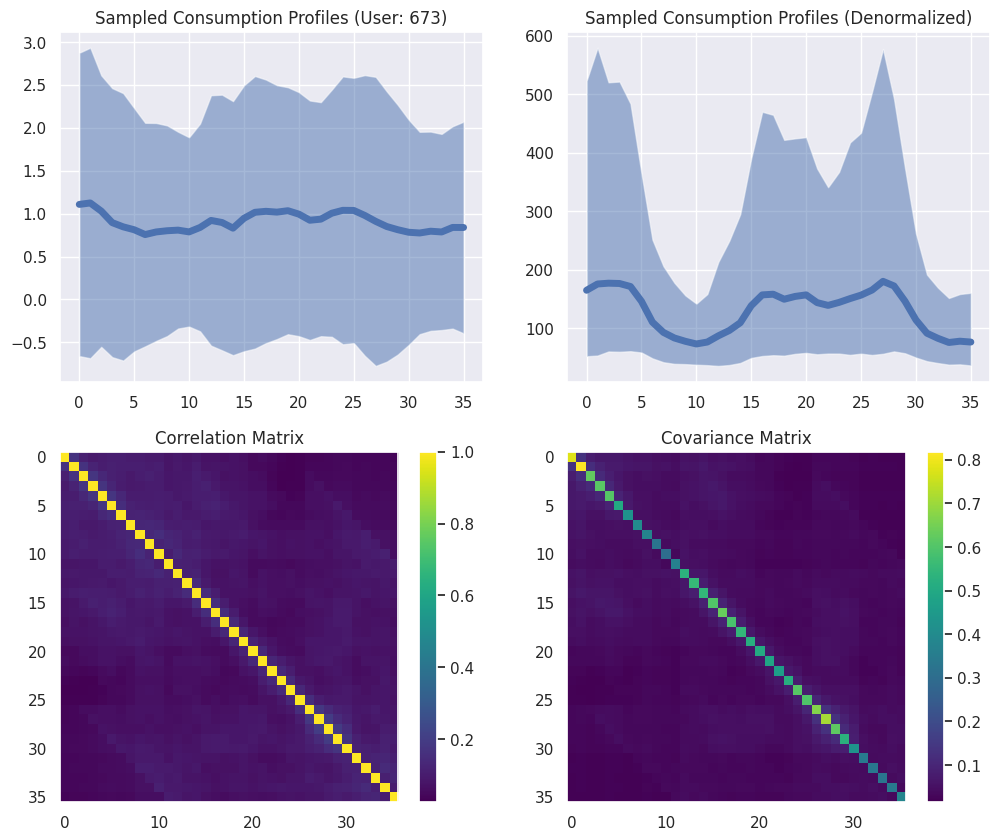

In [100]:
x_sample = model.sample(condition=torch.tensor(random_condition_set).float(), num_samples_prior=1, num_samples_likelihood=1)
x_mu = x_sample["params"]["mu"].detach()
x_sigma = x_sample["params"]["sigma"].detach()
# x_pi = x_sample["params"]["pi"].detach()
x_pi = torch.tensor([1.0])
x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()

x_tau = model.decoder.get_tau(x_sample["params"]["tau"]).detach()
x_Sigma = model.decoder.create_covariance_matrix(x_sample["params"])
x_Corr = x_Sigma/ (x_sigma[...,None]*x_sigma[:,None,:])

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0,0].plot(x_mu.T, lw=5)
ax[0,0].fill_between(np.arange(x_mu.shape[1]), (x_mu-2*x_sigma)[0], (x_mu+2*x_sigma)[0], alpha=0.5)
# ax[0].plot(x_pi.T, lw=1, linestyle='--')
ax[0,0].set_title(f"Sampled Consumption Profiles (User: {random_user_idx})")

ax[0,1].plot(x_mu_denorm.T, lw=5)
ax[0,1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
ax[0,1].set_title("Sampled Consumption Profiles (Denormalized)")

im = ax[1,0].imshow(x_Corr[0], aspect='auto', cmap='viridis', interpolation='nearest')
ax[1,0].set_title(f"Correlation Matrix")
ax[1,0].grid(False)
plt.colorbar(im)

im = ax[1,1].imshow(x_Sigma[0], aspect='auto', cmap='viridis', interpolation='none')
ax[1,1].set_title(f"Covariance Matrix")
ax[1,1].grid(False)
plt.colorbar(im)
plt.show()

### Reconstruction

In [244]:
### choose k random datapoints from the validation set
k = 5
random_idx = np.random.choice(len(X_val), k)
x_val = torch.tensor(X_val[random_idx]).float()
x_val_conditions = {k: v[random_idx] for k, v in conditions_val.items()}
x_rec, z_rec = model.reconstruct(x_val, torch.tensor(conditioner.transform(x_val_conditions)).float())

x_rec_mu = x_rec["params"]["mu"].detach().squeeze(0)
x_rec_sigma = x_rec["params"]["sigma"].detach().squeeze(0)
# x_rec_pi = x_rec["params"]["pi"].detach().squeeze(0)
x_rec_pi = torch.tensor([1.0])

x_tau = model.decoder.get_tau(x_rec["params"]["tau"]).detach().squeeze(0)
x_Sigma = model.decoder.create_covariance_matrix(x_rec["params"]).squeeze(0)
x_Corr = x_Sigma/ (x_rec_sigma[...,None]*x_rec_sigma[:,None,:])

x_val_denorm = utils.zero_preserved_log_denormalize(x_val.unsqueeze(0), nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()
x_rec_denorm = utils.zero_preserved_log_denormalize(x_rec_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()*x_rec_pi.numpy()
x_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(x_rec_mu - 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()*x_rec_pi.numpy()
x_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(x_rec_mu + 2*x_rec_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT).squeeze()*x_rec_pi.numpy()


In [245]:
##take sample

samples = model.decoder.sample(x_rec["params"],num_samples=1)
samples_denorm = utils.zero_preserved_log_denormalize(samples, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)


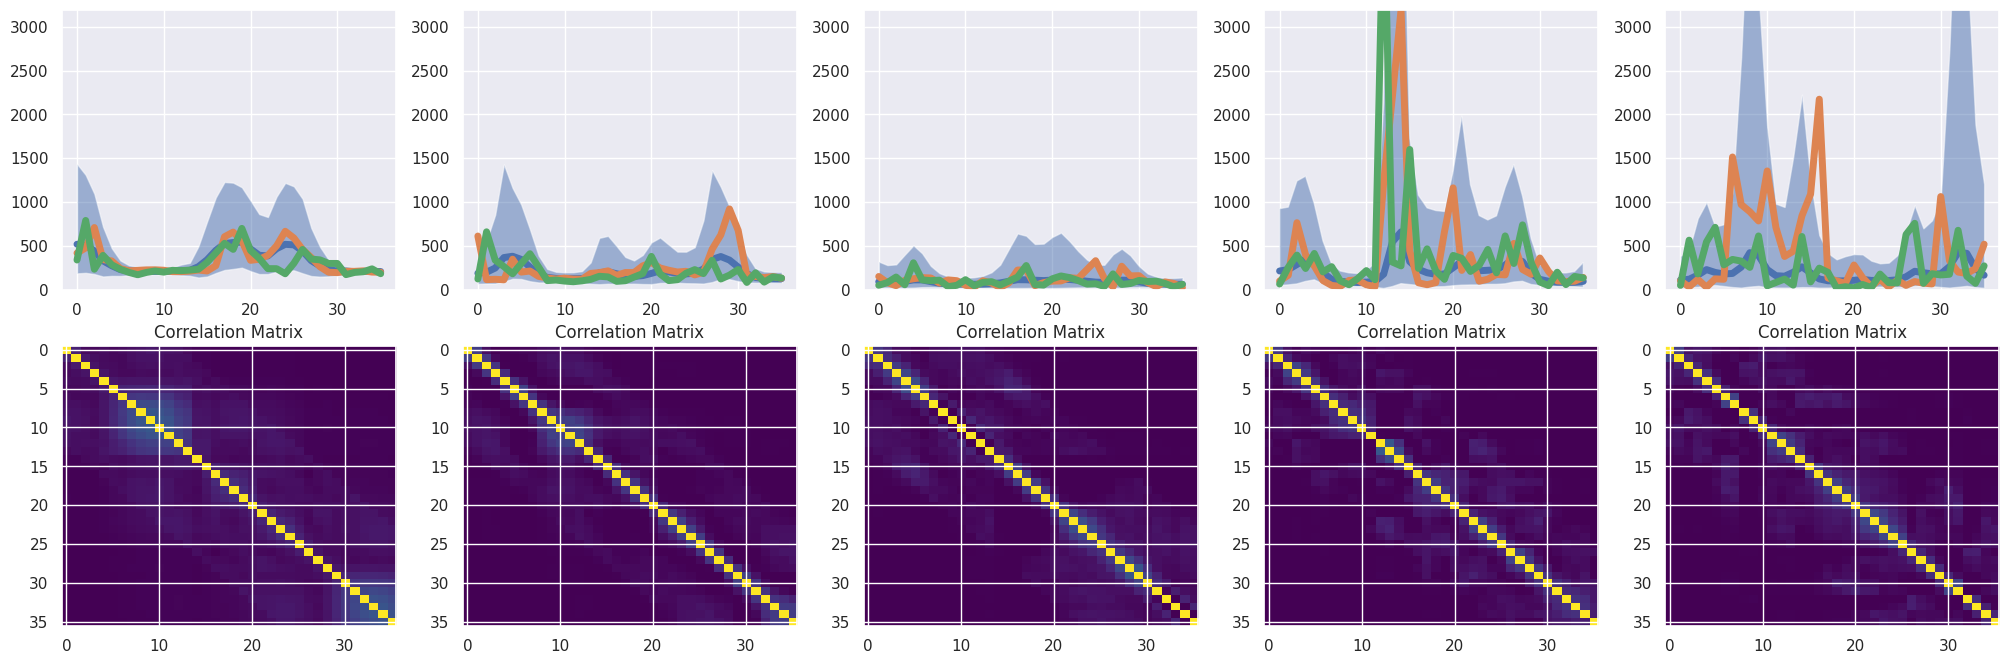

In [246]:
fig, ax = plt.subplots(2, 5, figsize=(25, 8))
for i in range(5):
    ax[0,i].plot(x_rec_denorm[i].T, lw=5)
    ax[0,i].fill_between(np.arange(x_val_denorm.shape[1]), x_rec_denorm_sigma_low[i].T, x_rec_denorm_sigma_high[i].T, alpha=0.5)
    ax[0,i].plot(x_val_denorm[i].T, lw=5)
    ax[0,i].plot(samples_denorm[:,0,i,:].squeeze().T, lw=5)
    ax[0,i].set_ylim([np.min(x_val_denorm).item()*0, np.max(x_val_denorm).item()])

    im = ax[1,i].imshow(x_Corr[i], aspect='auto', cmap='viridis', interpolation='none', vmin=0, vmax=1)
    ax[1,i].set_title(f"Correlation Matrix")
plt.show()


#### Reconstruction Free Validation Visualisation

In [108]:
sample_val_list = [model.sample(torch.tensor(conditioner.transform(x_val_conditions)).float()[[i]]) for i in range(k)]
sample_val_mu = torch.tensor(np.array([x["params"]["mu"].detach().squeeze(0) for x in sample_val_list]))
sample_val_sigma = torch.tensor(np.array([x["params"]["sigma"].detach().squeeze(0) for x in sample_val_list]))
# sample_val_pi = torch.tensor(np.array([x["params"]["pi"].detach().squeeze(0) for x in sample_val_list]))
sample_val_pi = torch.tensor([1.0])

sample_val_rec_denorm = utils.zero_preserved_log_denormalize(sample_val_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*sample_val_pi.numpy()
sample_val_rec_denorm_sigma_low = utils.zero_preserved_log_denormalize(sample_val_mu - 2*sample_val_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*sample_val_pi.numpy()
sample_val_rec_denorm_sigma_high = utils.zero_preserved_log_denormalize(sample_val_mu + 2*sample_val_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*sample_val_pi.numpy()

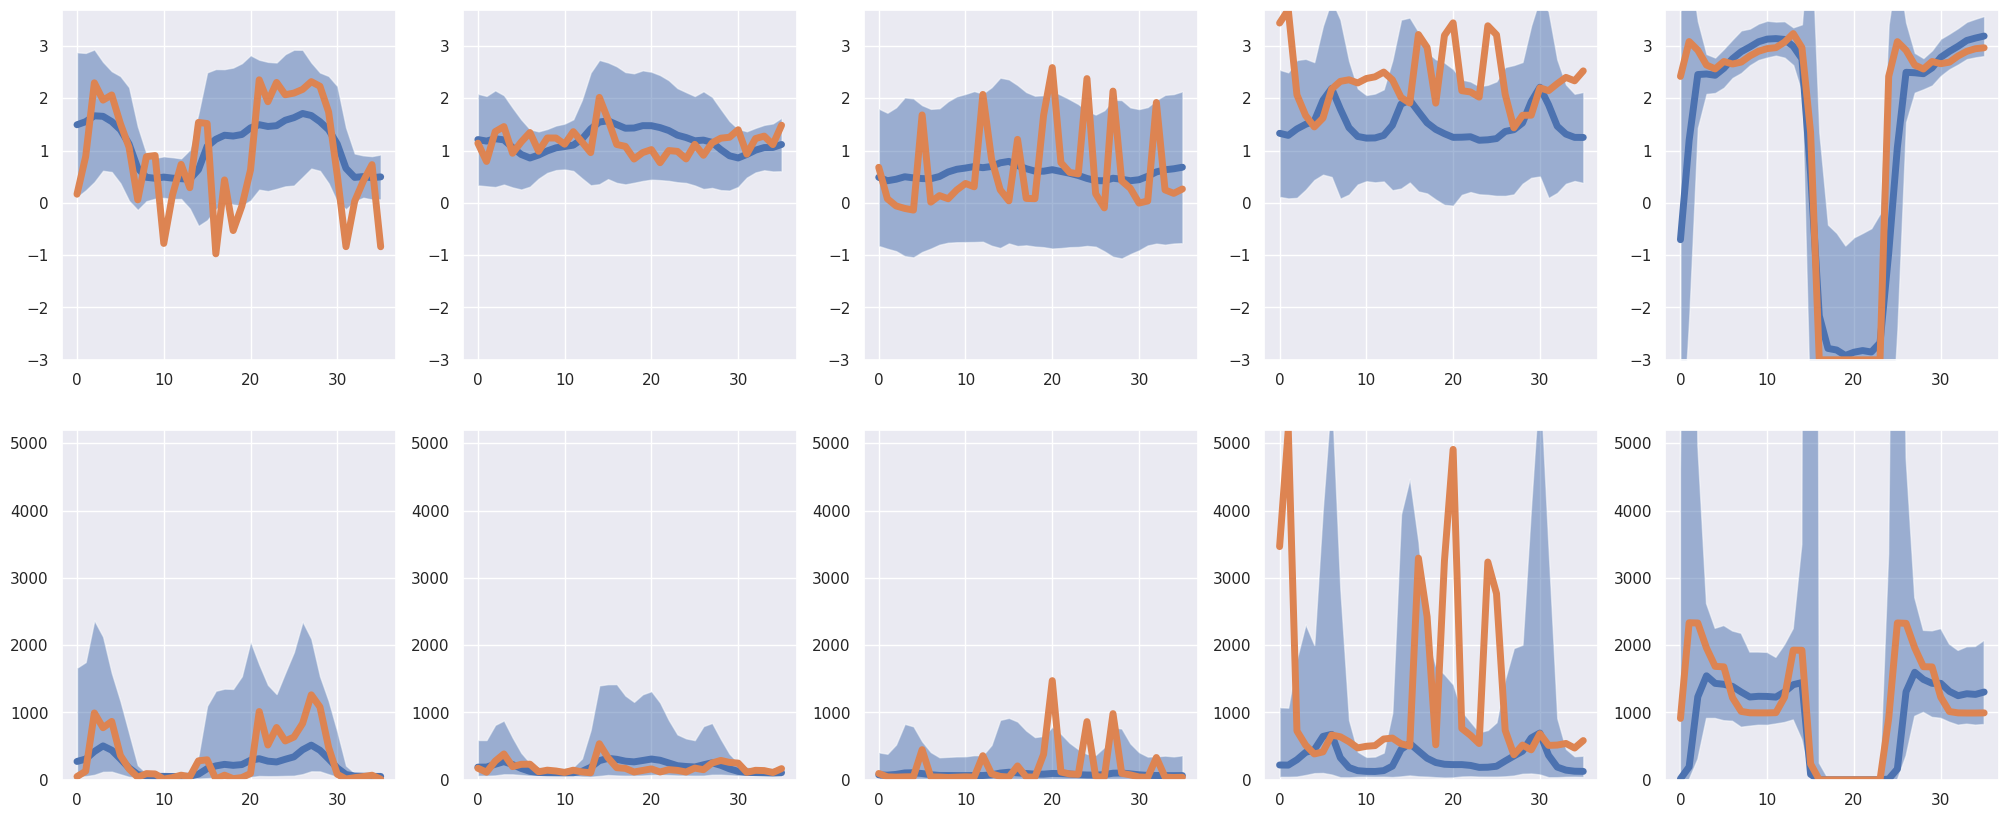

In [109]:
fig, ax = plt.subplots(2, k, figsize=(5*k, 10))

for i in range(k):
    ax[0, i].plot(sample_val_mu[i], lw=5)
    ax[0, i].fill_between(np.arange(x_val.shape[1]), (sample_val_mu-2*sample_val_sigma)[i], (sample_val_mu+2*sample_val_sigma)[i],alpha=0.5)
    ax[0, i].plot(x_val[i], lw=5)
    ax[0, i].set_ylim([torch.min(x_val).item(), torch.max(x_val).item()])

    ax[1, i].plot(sample_val_rec_denorm[i].T, lw=5)
    ax[1, i].fill_between(np.arange(x_val_denorm.shape[1]), sample_val_rec_denorm_sigma_low[i].T, sample_val_rec_denorm_sigma_high[i].T, alpha=0.5)
    ax[1, i].plot(x_val_denorm[i].T, lw=5)
    ax[1, i].set_ylim([np.min(x_val_denorm).item()*0, np.max(x_val_denorm).item()])

### Topic representatives

In [ ]:
random_conditions = conditioner.get_random_conditions(1)
print("{:<20}{:>5}".format("Condition", "Value"))
print("="*25)
for k, v in random_conditions[1].items(): print(f"{k:<20}" + " ".join([f"{x:.2f}" for x in v[0]]))

Condition           Value
months              1.00
weekdays            3.00
users               2.15 2.26 2.20 0.06 2.94 5.32 0.02 0.88 27.78 14.00 8.78 3.18 4.13 6.35 0.25 10.92 6.76 18.74 8.10 3.25


In [ ]:
for topic in range(NUM_TOPICS):
    topic_onehot = np.zeros((1, NUM_TOPICS))
    topic_onehot[0, topic] = 1.0
    random_conditions[0][0,-NUM_TOPICS:] = topic_onehot
    x_sample = model.sample(condition=torch.tensor(random_conditions[0]).float(), num_samples_prior=1, num_samples_likelihood=1)
    x_mu = x_sample["params"]["mu"].detach()
    x_sigma = x_sample["params"]["sigma"].detach()
    x_pi = x_sample["params"]["pi"].detach()
    x_mu_denorm = utils.zero_preserved_log_denormalize(x_mu, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
    x_sigma_upper_denorm = utils.zero_preserved_log_denormalize(x_mu+x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()
    x_sigma_lower_denorm = utils.zero_preserved_log_denormalize(x_mu-x_sigma, nonzero_mean, nonzero_std, log_input=LOG_SPACE, zero_id=ZERO_ID, shift=SHIFT)*x_pi.numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10, 2))
    fig.tight_layout()
    ax[0].plot(x_mu.T, lw=5)
    ax[0].fill_between(np.arange(x_mu.shape[1]), (x_mu-x_sigma)[0], (x_mu+x_sigma)[0], alpha=0.5)
    ax[0].set_title(f"Sampled Consumption Profiles (Topic {topic})")
    ax[0].set_ylim([-1, 5])
    
    ax[1].plot(x_mu_denorm.T, lw=5)
    ax[1].fill_between(np.arange(x_mu_denorm.shape[1]), x_sigma_lower_denorm[0], x_sigma_upper_denorm[0], alpha=0.5)
    ax[1].set_title(f"Sampled Consumption Profiles (Topic {topic} Denormalized)")
    ax[1].set_ylim([0, 4000])

    plt.show()
    

KeyError: 'pi'